<a href="https://colab.research.google.com/github/steensme/nba-predictions/blob/main/NBA_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://medium.com/analytics-vidhya/how-to-web-scrape-tables-online-using-python-and-beautifulsoup-36d5bafeb982

import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://www.espn.com/nba/stats/team/_/view/team/table/offensive/sort/fieldGoalPct/dir/desc"'
requests.get(url)
page = requests.get(url)

soup = BeautifulSoup(page.text, 'lxml')
# print(soup)

table_data = soup.find('table', class_ = 'Table Table--align-right')

headers = []
for i in table_data.find_all('th'):
    title = i.text
    headers.append(title)

team_names = []

team = soup.find('tbody')
for teamlogo in team.find_all('div', class_='flex items-start mr7'):
  teamname = teamlogo.find('img', class_='Image Logo Logo__sm')['title']
  team_names.append(teamname)

stats = pd.DataFrame(columns = headers)

for j in table_data.find_all('tr')[1:]:
        row_data = j.find_all('td')
        row = [tr.text for tr in row_data]
        length = len(stats)
        stats.loc[length] = row

stats.insert(0, 'Team', team_names)

print(stats)

In [69]:
# Scrape the past game results instead of importing them
url = 'https://www.basketball-reference.com/leagues/NBA_2022_games-december.html'
requests.get(url)
page = requests.get(url)

soup = BeautifulSoup(page.text, 'lxml')
# print(soup)

table_data = soup.find('table', id = 'schedule') #class_ = 'suppress_glossary sortable stats_table now_sortable')

headers = []
for i in table_data.thead.find_all('th'):
    title = i.text
    headers.append(title)

scores = pd.DataFrame(columns = headers[1:]) # Leave out 'Date' column becaues this is hard to scrape ('th' tag, not 'td')

for j in table_data.tbody.find_all('tr'):
  row_data = j.find_all('td')
  row = [tr.text for tr in row_data]
  length = len(scores)
  scores.loc[length] = row

In [78]:
# Drop Games that do not have scores yet
scores['PTS'] = scores['PTS'].replace('', np.nan, inplace=False)
scores = scores.dropna(subset=['PTS'], inplace=False)

scores

,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS,,,Attend.,Notes
0,7:00p,Atlanta Hawks,114,Indiana Pacers,111,Box Score,,"12,656",
1,7:00p,Denver Nuggets,103,Orlando Magic,108,Box Score,,"14,191",
2,7:00p,Minnesota Timberwolves,107,Washington Wizards,115,Box Score,,"15,318",
3,7:30p,Philadelphia 76ers,87,Boston Celtics,88,Box Score,,"19,156",
4,7:30p,Cleveland Cavaliers,111,Miami Heat,85,Box Score,,"19,600",
...,...,...,...,...,...,...,...,...,...
194,10:00p,Utah Jazz,120,Portland Trail Blazers,105,Box Score,,"17,828",
195,10:30p,Dallas Mavericks,94,Sacramento Kings,95,Box Score,,"16,071",
196,7:00p,Philadelphia 76ers,110,Brooklyn Nets,102,Box Score,,"17,920",
197,7:00p,Milwaukee Bucks,136,Orlando Magic,118,Box Score,,"15,855",


In [83]:
scores['result_v'] = scores.iloc[:,2].astype("int64") - scores.iloc[:,4].astype("int64")

In [84]:
print(scores)

    Start (ET)         Visitor/Neutral  PTS  ... Attend. Notes result_v
0        7:00p           Atlanta Hawks  114  ...  12,656              3
1        7:00p          Denver Nuggets  103  ...  14,191             -5
2        7:00p  Minnesota Timberwolves  107  ...  15,318             -8
3        7:30p      Philadelphia 76ers   87  ...  19,156             -1
4        7:30p     Cleveland Cavaliers  111  ...  19,600             26
..         ...                     ...  ...  ...     ...   ...      ...
194     10:00p               Utah Jazz  120  ...  17,828             15
195     10:30p        Dallas Mavericks   94  ...  16,071             -1
196      7:00p      Philadelphia 76ers  110  ...  17,920              8
197      7:00p         Milwaukee Bucks  136  ...  15,855             18
198      7:00p     Cleveland Cavaliers   93  ...  15,637            -17

[199 rows x 10 columns]


In [85]:
# make positive result a win for the visitor and a loss otherwise
scores.loc[scores['result_v'] > 0, 'visitor'] = 'W'
scores.loc[scores['result_v'] < 0, 'visitor'] = "L"

# make negative result v a win for the home and a loss otherwise
scores.loc[scores['result_v'] > 0, 'home'] = "W"
scores.loc[scores['result_v'] < 0, 'home'] = "L"

# Change Los Angeles Clippers to LA Clippers
scores["Visitor/Neutral"] = scores["Visitor/Neutral"].replace("Los Angeles Clippers", "LA Clippers", regex=True)
scores["Home/Neutral"] = scores["Home/Neutral"].replace("Los Angeles Clippers", "LA Clippers", regex=True)

In [86]:
# Make a table with only the teams, whether they were @ home and the win or loss
result1 = pd.DataFrame({'Team':scores['Visitor/Neutral'],'Site': 'V','result':scores['visitor']})
result2 = pd.DataFrame({'Team':scores['Home/Neutral'],'Site': 'H','result':scores['home']})

# combine the tables to get a probability of win based on stats
results = pd.concat([result1,result2])

In [87]:
stats

,Team,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF
0,Utah Jazz,34,115.9,41.6,86.9,47.8,15.1,41.6,36.4,17.6,23.1,76.4,10.6,37.0,47.6,22.8,7.2,5.3,13.6,18.8
1,Phoenix Suns,34,111.8,42.4,88.9,47.6,11.5,31.6,36.5,15.6,19.6,79.5,9.6,36.4,45.9,26.1,8.6,4.1,13.4,19.2
2,Chicago Bulls,32,110.8,41.4,87.0,47.6,11.3,29.8,38.0,16.7,20.5,81.3,8.9,33.8,42.8,23.9,7.7,4.8,12.6,18.6
3,Golden State Warriors,34,110.9,40.4,85.7,47.1,14.8,40.4,36.6,15.4,20.6,74.8,9.9,36.4,46.3,27.8,9.3,5.1,15.4,20.3
4,San Antonio Spurs,33,111.5,43.8,93.0,47.1,10.8,30.0,36.0,13.2,18.2,73.0,10.8,35.2,45.9,28.5,8.2,5.0,12.4,17.4
5,Brooklyn Nets,33,110.3,40.8,87.2,46.8,11.5,32.6,35.4,17.2,21.2,81.1,9.0,36.5,45.6,25.5,6.7,5.6,13.5,19.8
6,Washington Wizards,35,106.1,39.9,85.9,46.5,10.1,31.0,32.7,16.2,21.3,76.1,9.1,35.1,44.2,23.9,6.3,5.0,12.8,19.1
7,Los Angeles Lakers,36,110.3,41.4,89.5,46.2,11.8,33.9,34.6,15.8,21.8,72.7,9.6,36.4,45.9,24.3,8.3,5.7,15.3,20.4
8,Charlotte Hornets,36,115.2,42.7,92.5,46.2,14.2,37.5,37.9,15.6,20.9,74.7,10.6,33.1,43.8,26.8,8.9,5.3,12.5,19.3
9,Cleveland Cavaliers,35,107.4,39.5,85.9,46.0,12.6,35.3,35.7,15.7,19.9,79.1,10.1,35.3,45.3,25.3,7.6,4.3,14.2,17.0


In [88]:
# add the statistical data to the teams
merged = pd.merge(results, stats, on='Team', how='left')

merged

,Team,Site,result,GP,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OR,DR,REB,AST,STL,BLK,TO,PF
0,Atlanta Hawks,V,W,34,110.3,40.7,88.4,46.0,12.3,32.3,38.0,16.7,20.8,80.2,10.4,35.0,45.5,23.6,6.6,4.5,11.7,17.6
1,Denver Nuggets,V,L,33,105.8,39.9,86.8,46.0,12.6,36.6,34.5,13.3,17.4,76.2,8.4,34.2,42.6,25.6,7.5,4.0,12.8,18.9
2,Minnesota Timberwolves,V,L,34,108.1,39.2,91.3,42.9,14.1,41.6,34.0,15.6,20.4,76.5,12.5,32.8,45.3,23.6,8.6,5.7,14.5,22.3
3,Philadelphia 76ers,V,L,35,106.1,38.8,85.0,45.6,11.1,31.5,35.1,17.4,21.3,81.8,8.2,33.5,41.7,22.3,8.0,5.9,11.5,19.2
4,Cleveland Cavaliers,V,W,35,107.4,39.5,85.9,46.0,12.6,35.3,35.7,15.7,19.9,79.1,10.1,35.3,45.3,25.3,7.6,4.3,14.2,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,Portland Trail Blazers,H,W,34,108.3,39.0,86.7,45.0,13.3,37.8,35.1,17.0,21.6,78.5,9.7,33.7,43.5,22.6,7.6,4.8,13.1,19.7
394,Sacramento Kings,H,L,36,109.7,40.5,89.6,45.2,11.8,34.5,34.1,17.0,22.5,75.8,10.6,34.1,44.6,22.4,7.2,4.9,13.8,19.6
395,Brooklyn Nets,H,W,33,110.3,40.8,87.2,46.8,11.5,32.6,35.4,17.2,21.2,81.1,9.0,36.5,45.6,25.5,6.7,5.6,13.5,19.8
396,Orlando Magic,H,W,36,101.7,37.3,87.3,42.7,11.9,36.9,32.4,15.3,19.6,77.8,9.7,34.1,43.8,21.9,6.6,4.7,14.3,19.7


In [89]:
# Select only the attributes that it makes sense to study
import numpy as np
results_stats = pd.DataFrame({'Site':merged['Site'].astype("category"), 'PTS':pd.to_numeric(merged['PTS']), 'FG%':pd.to_numeric(merged['FG%']), 
                              '3P%':pd.to_numeric(merged['3P%']), 'FT%':pd.to_numeric(merged['FT%']), 'OR':pd.to_numeric(merged['OR']), 
                              'DR':pd.to_numeric(merged['DR']), 'AST':pd.to_numeric(merged['AST']), 'STL':pd.to_numeric(merged['STL']), 
                              'BLK':pd.to_numeric(merged['BLK']), 'TO':pd.to_numeric(merged['TO']), 'PF':pd.to_numeric(merged['PF']), 
                              'Result':merged['result'].astype("category")})
results_stats.Site = results_stats.Site.map({'V': 0, 'H':1})
results_stats.Result = results_stats.Result.map({'L': 0, 'W':1})

In [90]:
# Check for null values
is_NaN = merged.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = merged[row_has_NaN]
print(rows_with_NaN)

Empty DataFrame
Columns: [Team, Site, result, GP, PTS, FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT%, OR, DR, REB, AST, STL, BLK, TO, PF]
Index: []


<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 397
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Site    398 non-null    category
 1   PTS     398 non-null    float64 
 2   FG%     398 non-null    float64 
 3   3P%     398 non-null    float64 
 4   FT%     398 non-null    float64 
 5   OR      398 non-null    float64 
 6   DR      398 non-null    float64 
 7   AST     398 non-null    float64 
 8   STL     398 non-null    float64 
 9   BLK     398 non-null    float64 
 10  TO      398 non-null    float64 
 11  PF      398 non-null    float64 
 12  Result  398 non-null    category
dtypes: category(2), float64(11)
memory usage: 38.3 KB


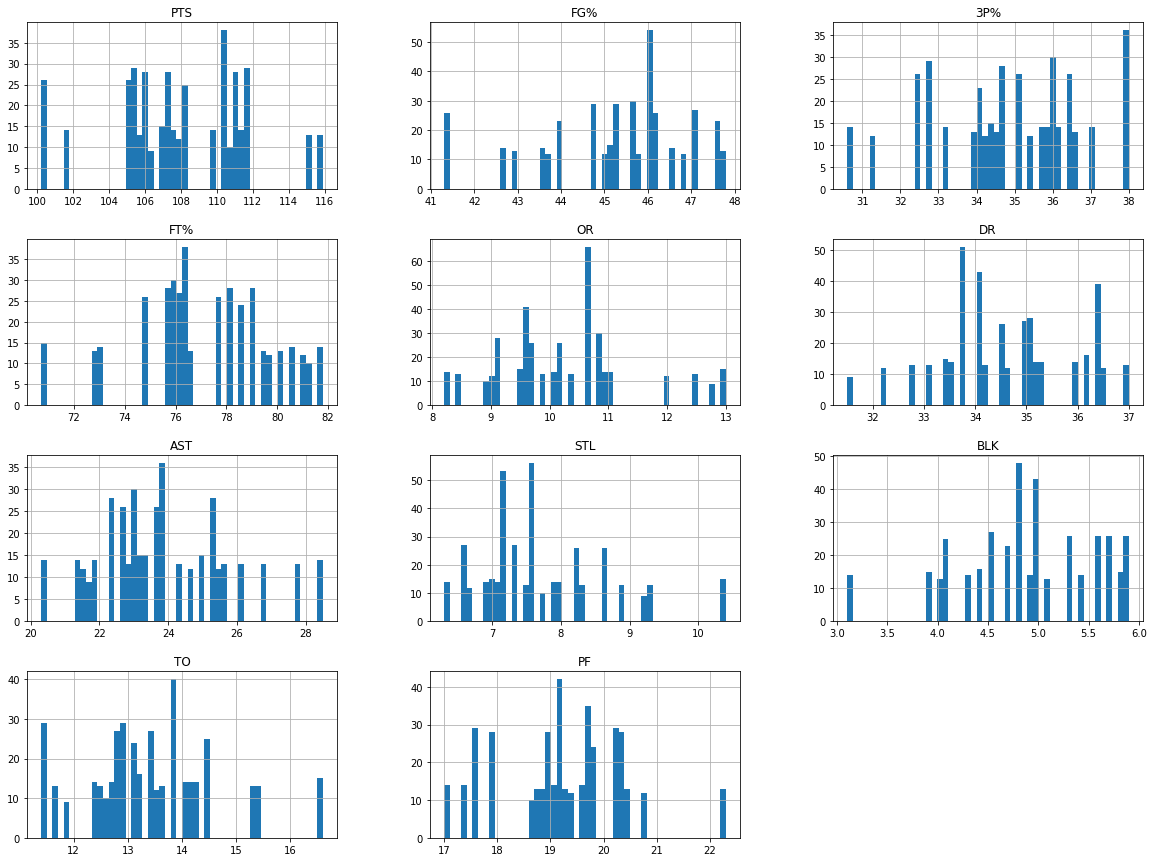

In [91]:
# Overall data statistics
results_stats.info()
results_stats.describe()
import matplotlib.pyplot as plt
results_stats.hist(bins=50, figsize=(20,15))
plt.show()

In [96]:
# Method from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

cols=['Site', 'PTS', 'FG%', '3P%', 'FT%', 'OR', 'DR', 'AST', 'STL', 'BLK', 'TO', 'PF']
# cols=['Site', 'FG%', '3P%', 'OR', 'AST', 'TO']

X = results_stats[cols]
y = results_stats.Result

In [97]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [98]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(max_iter=400) # needed to add this for the model to converge

# fit the model with data
logreg.fit(X_train,y_train)

# Make predictions on the test set
y_pred=logreg.predict(X_test)

In [99]:
# import the metrics class to test the model accuracy
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[34, 16],
       [27, 23]])

In [100]:
# Try out predicting the probabilities of W v. L for just one item from a dataframe
one_sample = X_test.iloc[1,:].tolist()

logreg.predict_proba([one_sample])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


array([[0.27152073, 0.72847927]])

In [101]:
# Scrape the current days games
url = 'https://www.espn.com/nba/schedule'
requests.get(url)
page = requests.get(url)

soup = BeautifulSoup(page.text, 'lxml')
# print(soup)

table_data = soup.find('table', class_ = 'schedule has-team-logos align-left')

team_names = []

schedule = soup.find('tbody')

for team in schedule.find_all("abbr"):
  team_name = team['title']
  team_names.append(team_name)

# print(team_names)

# Break the list into several lists
games = pd.DataFrame([team_names[i:i + 2] for i in range(0, len(team_names), 2)]) # help from https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks

games

,0,1
0,Miami Heat,Houston Rockets
1,Atlanta Hawks,Cleveland Cavaliers
2,LA Clippers,Toronto Raptors
3,San Antonio Spurs,Memphis Grizzlies
4,New York Knicks,Oklahoma City Thunder
5,Minnesota Timberwolves,Utah Jazz
6,Portland Trail Blazers,Los Angeles Lakers


In [ ]:
# Join the value in the first column to the stats and then predict the probability of winning
# Next, join the value in the second column to the stats and then predict the probability of winning
# Select the team with the higher probabiliyt as the team that will win

In [102]:
games.iloc[:,0]

0                Miami Heat
1             Atlanta Hawks
2               LA Clippers
3         San Antonio Spurs
4           New York Knicks
5    Minnesota Timberwolves
6    Portland Trail Blazers
Name: 0, dtype: object

In [103]:
visitor = pd.DataFrame({'Team': games.iloc[:,0], 'Site': 'V'})
visitor_stats = pd.merge(visitor, stats, on='Team', how='left')
home = pd.DataFrame({'Team': games.iloc[:,1], 'Site': 'H'})
home_stats = pd.merge(home, stats, on='Team', how='left')

In [104]:
visitor_trans = pd.DataFrame({'Site':visitor_stats['Site'].astype("category"), 'PTS':pd.to_numeric(visitor_stats['PTS']), 'FG%':pd.to_numeric(visitor_stats['FG%']), 
                              '3P%':pd.to_numeric(visitor_stats['3P%']), 'FT%':pd.to_numeric(visitor_stats['FT%']), 'OR':pd.to_numeric(visitor_stats['OR']), 
                              'DR':pd.to_numeric(visitor_stats['DR']), 'AST':pd.to_numeric(visitor_stats['AST']), 'STL':pd.to_numeric(visitor_stats['STL']), 
                              'BLK':pd.to_numeric(visitor_stats['BLK']), 'TO':pd.to_numeric(visitor_stats['TO']), 'PF':pd.to_numeric(visitor_stats['PF'])})
visitor_trans.Site = visitor_trans.Site.map({'V': 0, 'H':1})
home_trans = pd.DataFrame({'Site':home_stats['Site'].astype("category"), 'PTS':pd.to_numeric(home_stats['PTS']), 'FG%':pd.to_numeric(home_stats['FG%']), 
                              '3P%':pd.to_numeric(home_stats['3P%']), 'FT%':pd.to_numeric(home_stats['FT%']), 'OR':pd.to_numeric(home_stats['OR']), 
                              'DR':pd.to_numeric(home_stats['DR']), 'AST':pd.to_numeric(home_stats['AST']), 'STL':pd.to_numeric(home_stats['STL']), 
                              'BLK':pd.to_numeric(home_stats['BLK']), 'TO':pd.to_numeric(home_stats['TO']), 'PF':pd.to_numeric(home_stats['PF'])})
home_trans.Site = home_trans.Site.map({'V': 0, 'H':1})

In [105]:
v_prob = logreg.predict_proba(visitor_trans[cols])
h_prob = logreg.predict_proba(home_trans[cols])

In [106]:
# v_prob[:,0]
h_prob#[:,0]

array([[0.59663414, 0.40336586],
       [0.62692258, 0.37307742],
       [0.59250239, 0.40749761],
       [0.51991825, 0.48008175],
       [0.47951031, 0.52048969],
       [0.59694719, 0.40305281],
       [0.45961516, 0.54038484]])

In [107]:
games_prob = pd.DataFrame({'Visitor': games.iloc[:,0], 'Prob_V': v_prob[:,0], 'Home': games.iloc[:,1], 'Prob_H':h_prob[:,0]})

In [108]:
games_prob.Prob_V

0    0.679348
1    0.403056
2    0.550850
3    0.386116
4    0.343974
5    0.511341
6    0.535399
Name: Prob_V, dtype: float64

In [109]:
games_prob

,Visitor,Prob_V,Home,Prob_H
0,Miami Heat,0.679348,Houston Rockets,0.596634
1,Atlanta Hawks,0.403056,Cleveland Cavaliers,0.626923
2,LA Clippers,0.550850,Toronto Raptors,0.592502
3,San Antonio Spurs,0.386116,Memphis Grizzlies,0.519918
4,New York Knicks,0.343974,Oklahoma City Thunder,0.479510
5,Minnesota Timberwolves,0.511341,Utah Jazz,0.596947
6,Portland Trail Blazers,0.535399,Los Angeles Lakers,0.459615


In [110]:
prediction = []
margin = []
for row in games_prob.iterrows():
  if row[1].Prob_V > row[1].Prob_H:
    prediction.append(row[1].Visitor)
    margin.append(row[1].Prob_V - row[1].Prob_H)
  else:
    prediction.append(row[1].Home)
    margin.append(row[1].Prob_H - row[1].Prob_V)

In [111]:
games_pred = pd.DataFrame({'Visitor': games.iloc[:,0], 'Home': games.iloc[:,1], 'Prediction': prediction, 'Margin': margin})

In [112]:
games_pred

,Visitor,Home,Prediction,Margin
0,Miami Heat,Houston Rockets,Miami Heat,0.082714
1,Atlanta Hawks,Cleveland Cavaliers,Cleveland Cavaliers,0.223867
2,LA Clippers,Toronto Raptors,Toronto Raptors,0.041653
3,San Antonio Spurs,Memphis Grizzlies,Memphis Grizzlies,0.133803
4,New York Knicks,Oklahoma City Thunder,Oklahoma City Thunder,0.135536
5,Minnesota Timberwolves,Utah Jazz,Utah Jazz,0.085606
6,Portland Trail Blazers,Los Angeles Lakers,Portland Trail Blazers,0.075784
